In [1]:
import numpy as np
np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)
from numpy import genfromtxt
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from numpy import random
from numpy.random import randn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp
from scipy.linalg import block_diag
# read from csv and save corresponding column data to variables
# df = pd.read_csv('point1.csv')
# # transfer unit to meter
# y = df.y.div(1000)
# x = df.x.div(1000)
# # l = len(y)
# x_mean = np.mean(x)
# y_mean = np.mean(y)
process_std = 0.028
process_var = 0.028 ** 2
process_var_lateral = 0.019 **2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2
df1 = pd.read_csv(f'exp{1}_0107.csv')
uwb_x1 = df1.uwb_x
uwb_y1 = df1.uwb_y
vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)

# first nonzero value for uwb_x
ini_index1 = uwb_x1.ne(0).idxmax()

cmd_linear_x = df1['cmd_linear_x'].fillna(0.0)[ini_index1:]
cmd_angular_z = df1['cmd_angular_z'].fillna(0.0)[ini_index1:]
la_x = df1['la_x']
theta = df1.odom_filtered_yaw


#Notation used coming from: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/


def prediction(X_hat_t_1,P_t_1,F_t,B_t,U_t,Q_t):
    X_hat_t=F_t.dot(X_hat_t_1)+(B_t.dot(U_t).reshape(B_t.shape[0],-1) )
    P_t=np.diag(np.diag(F_t.dot(P_t_1).dot(F_t.transpose())))+Q_t
    return X_hat_t,P_t
    

def update(X_hat_t,P_t,Z_t,R_t,H_t):
    
    K_prime=P_t.dot(H_t.transpose()).dot( np.linalg.inv ( H_t.dot(P_t).dot(H_t.transpose()) +R_t ) )  
    print("K:\n",K_prime)
    
    X_t=X_hat_t+K_prime.dot(Z_t-H_t.dot(X_hat_t))
    P_t=P_t-K_prime.dot(H_t).dot(P_t)
    
    return X_t,P_t


# acceleration=la_x[0]
# delta_t = 1/20 # milisecond
delta_t = 0.01

N = len(uwb_x1[ini_index1:])
measurements = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])


In [52]:
delta_t

0.01

In [53]:
measurements

array([[5.72, 4.81],
       [5.72, 4.81],
       [5.72, 4.81],
       ...,
       [1.97, 2.32],
       [1.97, 2.32],
       [1.97, 2.32]])

In [61]:
#Transition matrix
F_t=np.array([ [1 ,0,delta_t,0] , [0,1,0,delta_t] , [0,0,1,0] , [0,0,0,1] ])

#Initial State cov
P_t= np.identity(4)*0.5

#Process cov
q_forward = Q_discrete_white_noise(dim=2, dt=delta_t, var=process_var)
q_lateral = Q_discrete_white_noise(dim=2, dt=delta_t, var=process_var_lateral)
Q_t= block_diag(q_forward, q_lateral)

#Control matrix
B_t=np.array( [ [0] , [0], [0] , [0] ])

#Control vector updated along with measurements
# U_t=acceleration

#Measurment Matrix
H_t = np.array([ [1, 0, 0, 0], [ 0, 1, 0, 0]])

#Measurment cov
R_t= np.array([[sensor_var, 0], [0, sensor_var_lateral]])

# Initial State
X_hat_t = np.array( [[0],[0],[0],[0]] )
print("X_hat_t",X_hat_t.shape)
print("P_t",P_t.shape)
print("F_t",F_t.shape)
print("B_t",B_t.shape)
print("Q_t",Q_t.shape)
print("R_t",R_t.shape)
print("H_t",H_t.shape)

mu0 = []
mu1 = []

for i in range(measurments.shape[0]):
    U_t = la_x[i]
    if U_t:
        print('*' * 40)
        print(f"U_t = {U_t}")
    X_hat_t,P_hat_t = prediction(X_hat_t,P_t,F_t,B_t,U_t,Q_t)
    print("Prediction:")
    print("X_hat_t:\n",X_hat_t,"\nP_t:\n",P_t)
    
    Z_t=measurements[i].transpose()
    Z_t=Z_t.reshape(Z_t.shape[0],-1)
    
    print(Z_t.shape)
    
    X_t,P_t=update(X_hat_t,P_hat_t,Z_t,R_t,H_t)
    print("Update:")
    print("X_t:\n",X_t,"\nP_t:\n",P_t)
    X_hat_t=X_t
    mu0.append(X_hat_t[0].tolist())
    mu1.append(X_hat_t[1].tolist())
    P_hat_t=P_t    

X_hat_t (4, 1)
P_t (4, 4)
F_t (4, 4)
B_t (4, 1)
Q_t (4, 4)
R_t (2, 2)
H_t (2, 4)
Prediction:
X_hat_t:
 [[0.]
 [0.]
 [0.]
 [0.]] 
P_t:
 [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
(2, 1)
K:
 [[0.98828212 0.        ]
 [0.         0.96969991]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65297374]
 [4.66425658]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00585952 0.         0.         0.        ]
 [0.         0.01515156 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000004]]
Prediction:
X_hat_t:
 [[5.65297374]
 [4.66425658]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00585952 0.         0.         0.        ]
 [0.         0.01515156 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000004]]
(2, 1)
K:
 [[0.49917746 0.00000001]
 [0.00000002 0.4931332 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.6864

Prediction:
X_hat_t:
 [[5.71873202]
 [4.79869944]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.0005312  0.         0.         0.        ]
 [0.         0.00097044 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000009 ]]
(2, 1)
K:
 [[0.08927563 0.00000002]
 [0.00000006 0.06130882]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71884522]
 [4.79877918]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052932 0.         0.         0.        ]
 [0.         0.00095795 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000094]]
Prediction:
X_hat_t:
 [[5.71884522]
 [4.79877918]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052932 0.         0.         0.        ]
 [0.         0.00095795 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000094]]
(2, 1)
K:
 [[0.08901155 0.00000002]
 [0.00000006 0.06060404]
 [0.      

K:
 [[0.08771979 0.00000002]
 [0.00000006 0.05525662]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71623884]
 [4.79482287]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052009 0.         0.         0.        ]
 [0.         0.00086338 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000199]]
Prediction:
X_hat_t:
 [[5.71623884]
 [4.79482287]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052009 0.         0.         0.        ]
 [0.         0.00086338 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000199]]
(2, 1)
K:
 [[0.08771853 0.00000002]
 [0.00000006 0.05523266]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71569158]
 [4.79400417]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052008 0.         0.         0.        ]
 [0.         0.00086301 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.       

Update:
X_t:
 [[5.70394869]
 [4.78592704]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000318]]
Prediction:
X_hat_t:
 [[5.70394869]
 [4.78592704]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000318]]
(2, 1)
K:
 [[0.08771226 0.00000002]
 [0.00000006 0.05503795]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.70360234]
 [4.7861512 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000321]]
Prediction:
X_hat_t:
 [[5.70360234]
 [4.7861512 ]
 [0.        ]
 [0.        ]] 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503338]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.68409518]
 [4.79938804]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000437]]
Prediction:
X_hat_t:
 [[5.68409518]
 [4.79938804]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000437]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503337]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.68373598]
 [4.79942172]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.       

Update:
X_t:
 [[5.69327328]
 [4.80185683]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000552]]
Prediction:
X_hat_t:
 [[5.69327328]
 [4.80185683]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000552]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503332]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69298617]
 [4.80175464]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000556]]
Prediction:
X_hat_t:
 [[5.69298617]
 [4.80175464]
 [0.        ]
 [0.        ]] 

Prediction:
X_hat_t:
 [[5.68701433]
 [4.80030346]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000668]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503338]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.68727621]
 [4.80028676]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000671]]
Prediction:
X_hat_t:
 [[5.68727621]
 [4.80028676]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000671]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503338]
 [0.      

 [0.         0.         0.         0.5000078 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503344]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.68879187]
 [4.78766396]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000783]]
Prediction:
X_hat_t:
 [[5.68879187]
 [4.78766396]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000783]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503344]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69065209]
 [4.78724218]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0

Prediction:
X_hat_t:
 [[5.71600226]
 [4.78346708]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000895]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550335 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71723003]
 [4.78327628]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000899]]
Prediction:
X_hat_t:
 [[5.71723003]
 [4.78327628]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50000899]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503351]
 [0.      

 [0.         0.        ]]
Update:
X_t:
 [[5.71918325]
 [4.79783028]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001018]]
Prediction:
X_hat_t:
 [[5.71918325]
 [4.79783028]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001018]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503357]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71837776]
 [4.79850002]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001022]]
Prediction:
X_hat_t:
 [[5.71837776]
 [4.79850002]
 [0

 [0.         0.         0.         0.50001112]]
Prediction:
X_hat_t:
 [[5.67249406]
 [4.79544291]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001112]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503362]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.67139818]
 [4.7956937 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001115]]
Prediction:
X_hat_t:
 [[5.67139818]
 [4.7956937 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001115]]
(2, 1)
K:
 [[0.08771224

Update:
X_t:
 [[5.65094506]
 [4.79479498]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001217]]
Prediction:
X_hat_t:
 [[5.65094506]
 [4.79479498]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001217]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503368]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65173929]
 [4.7945311 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000122 ]]
Prediction:
X_hat_t:
 [[5.65173929]
 [4.7945311 ]
 [0.        ]
 [0.        ]] 

 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001285]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503371]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65855615]
 [4.79154566]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001289]]
Prediction:
X_hat_t:
 [[5.65855615]
 [4.79154566]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001289]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503371]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65868279]
 [4.7914606 ]
 [

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001397]]
Prediction:
X_hat_t:
 [[5.66845338]
 [4.79315225]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001397]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503377]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.66858904]
 [4.79352911]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001401]]
Prediction:
X_hat_t:
 [[5.66858904]
 [4.79352911]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.68617089]
 [4.79512788]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000152 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503384]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.68826099]
 [4.79484567]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001523]]
Prediction:
X_hat_t:
 [[5.68826099]
 [4.79484567]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001523]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503384]
 [0.      

Prediction:
X_hat_t:
 [[5.70758637]
 [4.79083803]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001635]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550339 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.70779808]
 [4.79079191]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001639]]
Prediction:
X_hat_t:
 [[5.70779808]
 [4.79079191]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.0008599  0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001639]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550339 ]
 [0.      

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503396]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69342788]
 [4.79248749]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001758]]
Prediction:
X_hat_t:
 [[5.69342788]
 [4.79248749]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001758]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503396]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69400433]
 [4.79180026]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.       

Prediction:
X_hat_t:
 [[5.70840755]
 [4.79469337]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000187 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503402]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.70854723]
 [4.79443507]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001874]]
Prediction:
X_hat_t:
 [[5.70854723]
 [4.79443507]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001874]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503403]
 [0.      

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503409]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.80122103]
 [4.80929111]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001996]]
Prediction:
X_hat_t:
 [[5.80122103]
 [4.80929111]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50001996]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503409]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.80286818]
 [4.80988046]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.       

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503415]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.84667998]
 [4.8032016 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002108]]
****************************************
U_t = 0.0030186459833973
Prediction:
X_hat_t:
 [[5.84667998]
 [4.8032016 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002108]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503415]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.84609406]
 [4.8030254 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0

Prediction:
X_hat_t:
 [[5.80133509]
 [4.79729187]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000222 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503421]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.79946374]
 [4.79689057]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002224]]
****************************************
U_t = 0.0291653208209286
Prediction:
X_hat_t:
 [[5.79946374]
 [4.79689057]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002224]]
(2, 1

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002307]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503426]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.8200676 ]
 [4.77286809]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000231 ]]
****************************************
U_t = 0.0551615485899445
Prediction:
X_hat_t:
 [[5.8200676 ]
 [4.77286809]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000231 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503426]
 [0.    

Prediction:
X_hat_t:
 [[5.71052441]
 [4.72473277]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002408]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503431]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.70696992]
 [4.72337162]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002411]]
****************************************
U_t = 0.0808772486210002
Prediction:
X_hat_t:
 [[5.70696992]
 [4.72337162]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002411]]
(2, 1

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002513]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503437]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.64711889]
 [4.63717935]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002516]]
****************************************
U_t = 0.0904319750030485
Prediction:
X_hat_t:
 [[5.64711889]
 [4.63717935]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002516]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503437]
 [0.    

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503442]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65322875]
 [4.51519912]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002617]]
****************************************
U_t = 0.0736126543493525
Prediction:
X_hat_t:
 [[5.65322875]
 [4.51519912]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002617]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503442]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.65294555]
 [4.51161093]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0

Prediction:
X_hat_t:
 [[5.64189309]
 [4.44311875]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002718]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503448]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.64084992]
 [4.44129607]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002722]]
****************************************
U_t = 0.0313540050379124
Prediction:
X_hat_t:
 [[5.64084992]
 [4.44129607]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002722]]
(2, 1

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503453]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69232199]
 [4.41485307]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002812]]
****************************************
U_t = 0.0001594778624509
Prediction:
X_hat_t:
 [[5.69232199]
 [4.41485307]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002812]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503453]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.69474969]
 [4.41458598]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085991 0.         0.        ]
 [0

Prediction:
X_hat_t:
 [[5.74362247]
 [4.40501923]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000292 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503459]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.74330474]
 [4.40529334]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002924]]
****************************************
U_t = -0.0026994271376449
Prediction:
X_hat_t:
 [[5.74330474]
 [4.40529334]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50002924]]
(2, 

Update:
X_t:
 [[5.71888257]
 [4.37373689]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003025]]
****************************************
U_t = 0.012283546070205
Prediction:
X_hat_t:
 [[5.71888257]
 [4.37373689]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003025]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503464]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.71810346]
 [4.37188019]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003029]]
**************

Update:
X_t:
 [[5.64343837]
 [4.34044484]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000313 ]]
****************************************
U_t = 0.0207146802756014
Prediction:
X_hat_t:
 [[5.64343837]
 [4.34044484]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000313 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550347 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.64225966]
 [4.33876931]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003133]]
*************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503475]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.61596843]
 [4.25472982]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003231]]
****************************************
U_t = 0.0044053219833107
Prediction:
X_hat_t:
 [[5.61596843]
 [4.25472982]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003231]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503475]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.6145678 ]
 [4.25171778]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550348 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.5961408]
 [4.2005139]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003318]]
****************************************
U_t = -0.0156960002658753
Prediction:
X_hat_t:
 [[5.5961408]
 [4.2005139]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003318]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550348 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.59560218]
 [4.19938493]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.      

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503485]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.59650184]
 [4.1704702 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003422]]
****************************************
U_t = -0.0323529239867117
Prediction:
X_hat_t:
 [[5.59650184]
 [4.1704702 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003422]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503485]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.59593155]
 [4.16989397]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.66373347]
 [4.1939197 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003516]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550349 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.66691449]
 [4.19535503]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000352 ]]
****************************************
U_t = -0.0404022391689882
Prediction:
X_hat_t:
 [[5.66691449]
 [4.19535503]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000352 ]]
(2, 

Prediction:
X_hat_t:
 [[5.58841851]
 [4.21220232]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003639]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503497]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.58504874]
 [4.21208111]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003642]]
****************************************
U_t = -0.0419203440730891
Prediction:
X_hat_t:
 [[5.58504874]
 [4.21208111]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003642]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503502]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.53055422]
 [4.2104265 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003744]]
****************************************
U_t = -0.0395847168565013
Prediction:
X_hat_t:
 [[5.53055422]
 [4.2104265 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003744]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503502]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.52962849]
 [4.21040303]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503507]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50233501]
 [4.21010961]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000383 ]]
****************************************
U_t = -0.0357178790947399
Prediction:
X_hat_t:
 [[5.50233501]
 [4.21010961]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000383 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503507]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50125308]
 [4.21010358]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.49078541]
 [4.21393111]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003939]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503513]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.49071652]
 [4.21371476]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003942]]
****************************************
U_t = -0.0305357986195024
Prediction:
X_hat_t:
 [[5.49071652]
 [4.21371476]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50003942]]
(2, 

Update:
X_t:
 [[5.47672575]
 [4.20951001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004054]]
****************************************
U_t = 2.8434118224083117e-05
Prediction:
X_hat_t:
 [[5.47672575]
 [4.20951001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004054]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503519]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.47613582]
 [4.20898663]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085992 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004058]]
*********

 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004155]]
****************************************
U_t = 0.0290962201167183
Prediction:
X_hat_t:
 [[5.506722 ]
 [4.1565673]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004155]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503524]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50700952]
 [4.15180304]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004159]]
****************************************
U_t = 0.0290962201167183
Predicti

Update:
X_t:
 [[5.49668236]
 [4.07960001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004256]]
****************************************
U_t = 0.0587528575735934
Prediction:
X_hat_t:
 [[5.49668236]
 [4.07960001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004256]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550353 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.49258774]
 [4.07687026]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000426 ]]
*************

Prediction:
X_hat_t:
 [[5.50629436]
 [3.94443627]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004364]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503536]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50749652]
 [3.9419907 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004368]]
****************************************
U_t = 0.0723441526598661
Prediction:
X_hat_t:
 [[5.50749652]
 [3.9419907 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004368]]
(2, 1

****************************************
U_t = 0.0542831413300888
Prediction:
X_hat_t:
 [[5.50516478]
 [3.90350871]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004455]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550354 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50471177]
 [3.9022149 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004458]]
****************************************
U_t = 0.0542831413300888
Prediction:
X_hat_t:
 [[5.50471177]
 [3.9022149 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5       

 [0.         0.        ]]
Update:
X_t:
 [[5.50082354]
 [3.87734689]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004527]]
****************************************
U_t = 0.0284784366436115
Prediction:
X_hat_t:
 [[5.50082354]
 [3.87734689]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004527]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503544]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50075131]
 [3.8763922 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         

Prediction:
X_hat_t:
 [[5.50006906]
 [3.87133341]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004624]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550355 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.500063  ]
 [3.87126002]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004628]]
****************************************
U_t = -0.0016940321499662
Prediction:
X_hat_t:
 [[5.500063  ]
 [3.87126002]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004628]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503555]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50126551]
 [3.87350225]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004736]]
****************************************
U_t = -0.0287110186148271
Prediction:
X_hat_t:
 [[5.50126551]
 [3.87350225]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004736]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503555]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50115451]
 [3.87385985]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.50099345]
 [3.87537023]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000483 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550356 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.50178344]
 [3.87507467]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004834]]
****************************************
U_t = -0.0375053595775671
Prediction:
X_hat_t:
 [[5.50178344]
 [3.87507467]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004834]]
(2, 

Prediction:
X_hat_t:
 [[5.49668864]
 [3.86846358]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004942]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503566]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.49697908]
 [3.86799778]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004946]]
****************************************
U_t = -0.0406464611074108
Prediction:
X_hat_t:
 [[5.49697908]
 [3.86799778]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50004946]]
(2, 

 [0.         0.         0.         0.50005054]]
****************************************
U_t = -0.0391166746162489
Prediction:
X_hat_t:
 [[5.49072689]
 [3.85663852]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005054]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503572]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.49066313]
 [3.85682352]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005058]]
****************************************
U_t = -0.0391166746162489
Prediction:
X_hat_t:
 [[5.49066313]
 [3.85682352]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.     

Prediction:
X_hat_t:
 [[5.48870717]
 [3.85905538]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005166]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503578]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.48882057]
 [3.85855701]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000517 ]]
****************************************
U_t = -0.034545078062438
Prediction:
X_hat_t:
 [[5.48882057]
 [3.85855701]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000517 ]]
(2, 1

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503584]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.47490738]
 [3.87254527]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005271]]
****************************************
U_t = -0.0308447331567674
Prediction:
X_hat_t:
 [[5.47490738]
 [3.87254527]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085993 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005271]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503584]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.47447694]
 [3.87405626]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.44932866]
 [3.91861068]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005375]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550359 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.44851043]
 [3.91813678]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005379]]
****************************************
U_t = -0.0165813614686618
Prediction:
X_hat_t:
 [[5.44851043]
 [3.91813678]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005379]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503595]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.44346262]
 [3.89654836]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005476]]
****************************************
U_t = 0.0122577017191156
Prediction:
X_hat_t:
 [[5.44346262]
 [3.89654836]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005476]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503595]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.44228179]
 [3.89508724]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0

Update:
X_t:
 [[5.32449632]
 [3.86323542]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005592]]
****************************************
U_t = 0.0449529610607451
Prediction:
X_hat_t:
 [[5.32449632]
 [3.86323542]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005592]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503601]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.32147057]
 [3.86250699]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005595]]
*************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503606]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.25942227]
 [3.8543355 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005682]]
****************************************
U_t = 0.066048123581402
Prediction:
X_hat_t:
 [[5.25942227]
 [3.8543355 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005682]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503606]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.25684157]
 [3.85354653]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.

Update:
X_t:
 [[5.14615726]
 [3.76893904]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000579 ]]
****************************************
U_t = 0.0755762799367125
Prediction:
X_hat_t:
 [[5.14615726]
 [3.76893904]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000579 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503612]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.14035446]
 [3.76404418]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005794]]
*************

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005892]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503617]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.02098391]
 [3.66249385]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005895]]
****************************************
U_t = 0.0500620372074282
Prediction:
X_hat_t:
 [[5.02098391]
 [3.66249385]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50005895]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503617]
 [0.    

Update:
X_t:
 [[4.96795041]
 [3.58900088]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006003]]
****************************************
U_t = 0.0088522771571477
Prediction:
X_hat_t:
 [[4.96795041]
 [3.58900088]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006003]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503623]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.96725306]
 [3.58740478]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006007]]
*************

Prediction:
X_hat_t:
 [[4.9456525 ]
 [3.55811185]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006108]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503629]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.94515671]
 [3.55711504]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006112]]
****************************************
U_t = -0.0209867671326159
Prediction:
X_hat_t:
 [[4.94515671]
 [3.55711504]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006112]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503635]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.92913172]
 [3.54313206]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000622 ]]
****************************************
U_t = -0.0368048958907079
Prediction:
X_hat_t:
 [[4.92913172]
 [3.54313206]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000622 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503635]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.92833075]
 [3.54295969]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [

 [0.         0.        ]]
Update:
X_t:
 [[4.931107  ]
 [3.53883855]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006336]]
****************************************
U_t = -0.0426079600480902
Prediction:
X_hat_t:
 [[4.931107  ]
 [3.53883855]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006336]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503641]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.93013278]
 [3.53780174]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.        

Prediction:
X_hat_t:
 [[4.92601876]
 [3.55205933]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006444]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503647]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.92549084]
 [3.55139563]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006447]]
****************************************
U_t = -0.041455916398365
Prediction:
X_hat_t:
 [[4.92549084]
 [3.55139563]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085994 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006447]]
(2, 1

Update:
X_t:
 [[4.93360511]
 [3.5443053 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006559]]
****************************************
U_t = -0.0376715858967688
Prediction:
X_hat_t:
 [[4.93360511]
 [3.5443053 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006559]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503653]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.93416602]
 [3.54461872]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006563]]
************

Update:
X_t:
 [[4.93400564]
 [3.57351028]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006671]]
****************************************
U_t = -0.031464638631432
Prediction:
X_hat_t:
 [[4.93400564]
 [3.57351028]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006671]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503659]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.93365429]
 [3.57386746]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006675]]
*************

Prediction:
X_hat_t:
 [[4.95238225]
 [3.61462662]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000678 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503665]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.95305042]
 [3.61602309]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006783]]
****************************************
U_t = -0.0261253510221909
Prediction:
X_hat_t:
 [[4.95305042]
 [3.61602309]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006783]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550367 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.92444639]
 [3.61462958]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006891]]
****************************************
U_t = -0.0203696897122523
Prediction:
X_hat_t:
 [[4.92444639]
 [3.61462958]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006891]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503671]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.92317927]
 [3.61162294]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[4.90347994]
 [3.54969887]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50006996]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503676]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.90405183]
 [3.54806434]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007   ]]
****************************************
U_t = -0.0167646079934861
Prediction:
X_hat_t:
 [[4.90405183]
 [3.54806434]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007   ]]
(2, 

 [0.         0.         0.         0.50007101]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503682]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.9608155 ]
 [3.56199981]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007104]]
****************************************
U_t = -0.0144926886637142
Prediction:
X_hat_t:
 [[4.9608155 ]
 [3.56199981]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007104]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503682]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.96688383]
 [3.56739343]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.    

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007202]]
****************************************
U_t = -0.0129289641824237
Prediction:
X_hat_t:
 [[4.98517507]
 [3.67381685]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007202]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503687]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.98559827]
 [3.67580825]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007206]]
****************************************
U_t = -0.0125936727837176
P

Update:
X_t:
 [[5.005874  ]
 [3.67835853]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007303]]
****************************************
U_t = -0.0111468641054448
Prediction:
X_hat_t:
 [[5.005874  ]
 [3.67835853]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007303]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503693]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.00799015]
 [3.67899924]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007307]]
************

 [0.         0.        ]]
Update:
X_t:
 [[4.95607767]
 [3.6874252 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007404]]
****************************************
U_t = -0.0089069044478099
Prediction:
X_hat_t:
 [[4.95607767]
 [3.6874252 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007404]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503698]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.95291322]
 [3.68976838]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.        

U_t = -0.0069087162152253
Prediction:
X_hat_t:
 [[5.01989083]
 [3.73113774]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007502]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503703]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.02691739]
 [3.73327661]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007505]]
****************************************
U_t = -0.0069087162152253
Prediction:
X_hat_t:
 [[5.02691739]
 [3.73327661]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.

 [0.         0.         0.         0.50007606]]
****************************************
U_t = -0.0053347734724317
Prediction:
X_hat_t:
 [[5.08062834]
 [3.78015467]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007606]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503709]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.08145035]
 [3.78069653]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000761 ]]
****************************************
U_t = -0.0053347734724317
Prediction:
X_hat_t:
 [[5.08145035]
 [3.78069653]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085995 0.     

 [0.         0.        ]]
Update:
X_t:
 [[5.13715666]
 [3.78786487]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007704]]
****************************************
U_t = -0.0049139105037851
Prediction:
X_hat_t:
 [[5.13715666]
 [3.78786487]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007704]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503714]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.1391603 ]
 [3.78798238]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.        

 [[5.17523379]
 [3.79657304]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000779 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503719]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.17652896]
 [3.79676165]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007794]]
****************************************
U_t = -0.0046719640173074
Prediction:
X_hat_t:
 [[5.17652896]
 [3.79676165]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007794]]
(2, 1)
K:
 [[0.08771224 0

Update:
X_t:
 [[5.20182976]
 [3.78868806]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000791 ]]
****************************************
U_t = 0.0016164869498457
Prediction:
X_hat_t:
 [[5.20182976]
 [3.78868806]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000791 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503725]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.20166927]
 [3.78876027]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50007913]]
*************

Update:
X_t:
 [[5.09900975]
 [3.77313566]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008025]]
****************************************
U_t = 0.0285080880323727
Prediction:
X_hat_t:
 [[5.09900975]
 [3.77313566]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008025]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503731]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.094711  ]
 [3.77131196]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008029]]
*************

Prediction:
X_hat_t:
 [[5.03814531]
 [3.68135225]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000813 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503737]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.03830799]
 [3.67852596]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008133]]
****************************************
U_t = 0.0594471524340335
Prediction:
X_hat_t:
 [[5.03830799]
 [3.67852596]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008133]]
(2, 1

Update:
X_t:
 [[5.06607588]
 [3.55314338]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008245]]
****************************************
U_t = 0.0841389889776597
Prediction:
X_hat_t:
 [[5.06607588]
 [3.55314338]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008245]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503743]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.0637887 ]
 [3.54856738]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008249]]
*************

Prediction:
X_hat_t:
 [[5.00112198]
 [3.45044692]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008354]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503749]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.99926932]
 [3.44712007]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008357]]
****************************************
U_t = 0.0839849869597444
Prediction:
X_hat_t:
 [[4.99926932]
 [3.44712007]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008357]]
(2, 1

Update:
X_t:
 [[4.96108102]
 [3.36057089]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008473]]
****************************************
U_t = 0.0481369118558211
Prediction:
X_hat_t:
 [[4.96108102]
 [3.36057089]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008473]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503755]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.9609862 ]
 [3.35888835]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008476]]
*************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550376 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.96994708]
 [3.32393976]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000857 ]]
****************************************
U_t = 0.0064608057131124
Prediction:
X_hat_t:
 [[4.96994708]
 [3.32393976]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000857 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550376 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.9690746]
 [3.3220718]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.   

Prediction:
X_hat_t:
 [[4.95817049]
 [3.294307  ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008682]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503766]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.95745384]
 [3.29351958]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008686]]
****************************************
U_t = -0.0212133510987096
Prediction:
X_hat_t:
 [[4.95745384]
 [3.29351958]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008686]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503772]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.95520936]
 [3.28592073]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008794]]
****************************************
U_t = -0.0178150559092407
Prediction:
X_hat_t:
 [[4.95520936]
 [3.28592073]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008794]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503772]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.95562955]
 [3.28559487]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085996 0.         0.        ]
 [

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503778]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.00533465]
 [3.25264519]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008902]]
****************************************
U_t = 0.0071098563436659
Prediction:
X_hat_t:
 [[5.00533465]
 [3.25264519]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50008902]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503778]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.00749811]
 [3.2502981 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009011]]
****************************************
U_t = 0.0150852395211992
Prediction:
X_hat_t:
 [[5.07099588]
 [3.17105888]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009011]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503784]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.07266278]
 [3.16824871]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009014]]
****************************************
U_t = 0.0150852395211992
Pre

Prediction:
X_hat_t:
 [[5.10911812]
 [3.10548413]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009112]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503789]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.11094971]
 [3.10408154]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009115]]
****************************************
U_t = 0.0003887579184778
Prediction:
X_hat_t:
 [[5.11094971]
 [3.10408154]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009115]]
(2, 1

Prediction:
X_hat_t:
 [[5.14060516]
 [3.09173557]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009227]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503795]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.1414292 ]
 [3.09164005]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009231]]
****************************************
U_t = -0.0220823765285852
Prediction:
X_hat_t:
 [[5.1414292 ]
 [3.09164005]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009231]]
(2, 

Prediction:
X_hat_t:
 [[5.14792543]
 [3.08214864]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009332]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503801]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.1481074 ]
 [3.08148001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009335]]
****************************************
U_t = -0.0329014678859159
Prediction:
X_hat_t:
 [[5.1481074 ]
 [3.08148001]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009335]]
(2, 

 [[0.08771224 0.00000002]
 [0.00000006 0.05503806]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.18773981]
 [3.0716873 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009426]]
****************************************
U_t = -0.0370615160410859
Prediction:
X_hat_t:
 [[5.18773981]
 [3.0716873 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009426]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503806]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.18881518]
 [3.07049368]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0. 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503809]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.1870211 ]
 [3.05464208]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009487]]
****************************************
U_t = -0.0377255172721128
Prediction:
X_hat_t:
 [[5.1870211 ]
 [3.05464208]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009487]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503809]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.18640527]
 [3.0538362 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.08724819]
 [3.06471702]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009606]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503815]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.08573531]
 [3.06390702]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000961 ]]
****************************************
U_t = -0.0359366397748294
Prediction:
X_hat_t:
 [[5.08573531]
 [3.06390702]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5000961 ]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503821]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.06291412]
 [3.0308169 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009707]]
****************************************
U_t = -0.0328844723662359
Prediction:
X_hat_t:
 [[5.06291412]
 [3.0308169 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009707]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503821]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.06265851]
 [3.02967117]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[5.06550829]
 [3.02600182]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009798]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503826]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.06502515]
 [3.02622188]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009801]]
****************************************
U_t = -0.0280427906786211
Prediction:
X_hat_t:
 [[5.06502515]
 [3.02622188]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009801]]
(2, 

Update:
X_t:
 [[5.07150822]
 [3.0286523 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009906]]
****************************************
U_t = -0.0238843021835189
Prediction:
X_hat_t:
 [[5.07150822]
 [3.0286523 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009906]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503831]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.07225305]
 [3.02817609]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50009909]]
************

Prediction:
X_hat_t:
 [[5.06276896]
 [3.11124818]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010014]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503837]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.06252609]
 [3.11448178]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010018]]
****************************************
U_t = -0.0204828557056367
Prediction:
X_hat_t:
 [[5.06252609]
 [3.11448178]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085997 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010018]]
(2, 

Update:
X_t:
 [[5.06302878]
 [3.16470856]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001013 ]]
****************************************
U_t = -0.017348977934894
Prediction:
X_hat_t:
 [[5.06302878]
 [3.16470856]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001013 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503843]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.06276312]
 [3.1649998 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010133]]
*************

Update:
X_t:
 [[5.0169601 ]
 [3.16864007]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010216]]
****************************************
U_t = -0.0143523858095779
Prediction:
X_hat_t:
 [[5.0169601 ]
 [3.16864007]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010216]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503848]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.01810386]
 [3.16871492]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001022 ]]
************

Update:
X_t:
 [[5.03346973]
 [3.17322456]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010332]]
****************************************
U_t = -0.0111505433977337
Prediction:
X_hat_t:
 [[5.03346973]
 [3.17322456]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010332]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503854]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.03316539]
 [3.17304709]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010335]]
************

Prediction:
X_hat_t:
 [[5.03911643]
 [3.18374232]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001044 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550386 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.03919393]
 [3.18408674]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010444]]
****************************************
U_t = -0.0083220270858924
Prediction:
X_hat_t:
 [[5.03919393]
 [3.18408674]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010444]]
(2, 

Prediction:
X_hat_t:
 [[5.03995318]
 [3.1886141 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010556]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503866]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.03995728]
 [3.18813999]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010559]]
****************************************
U_t = -0.0065083950218925
Prediction:
X_hat_t:
 [[5.03995728]
 [3.18813999]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010559]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503872]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.04561992]
 [3.18397468]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010664]]
****************************************
U_t = -0.0008144096636548
Prediction:
X_hat_t:
 [[5.04561992]
 [3.18397468]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010664]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503872]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.0460041 ]
 [3.18375592]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [

Update:
X_t:
 [[5.03397914]
 [3.18894594]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010787]]
****************************************
U_t = 0.0321925463976879
Prediction:
X_hat_t:
 [[5.03397914]
 [3.18894594]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010787]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503879]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[5.032753  ]
 [3.18900396]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001079 ]]
*************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503884]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.9768908 ]
 [3.19253492]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010891]]
****************************************
U_t = 0.0635666771212557
Prediction:
X_hat_t:
 [[4.9768908 ]
 [3.19253492]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50010891]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503884]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.97277791]
 [3.19294579]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0

 [0.         0.         0.         0.50011007]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550389 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.82036008]
 [3.19312499]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001101 ]]
****************************************
U_t = 0.0842572769183946
Prediction:
X_hat_t:
 [[4.82036008]
 [3.19312499]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001101 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550389 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.81506576]
 [3.19295299]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.     

Prediction:
X_hat_t:
 [[4.67045563]
 [3.19814323]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011119]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503896]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.66690718]
 [3.19824542]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011122]]
****************************************
U_t = 0.0811874967541106
Prediction:
X_hat_t:
 [[4.66690718]
 [3.19824542]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011122]]
(2, 1

Update:
X_t:
 [[4.59154136]
 [3.19822628]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011223]]
****************************************
U_t = 0.0487443736324439
Prediction:
X_hat_t:
 [[4.59154136]
 [3.19822628]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011223]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503902]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.58965192]
 [3.19777351]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085998 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011227]]
*************

Prediction:
X_hat_t:
 [[4.56119615]
 [3.19948983]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011328]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503907]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.56021411]
 [3.19951791]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011332]]
****************************************
U_t = 0.0074267930863495
Prediction:
X_hat_t:
 [[4.56021411]
 [3.19951791]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011332]]
(2, 1

Prediction:
X_hat_t:
 [[4.53458335]
 [3.20335343]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011436]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503913]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.53418133]
 [3.20316886]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001144 ]]
****************************************
U_t = -0.0203463382424245
Prediction:
X_hat_t:
 [[4.53418133]
 [3.20316886]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001144 ]]
(2, 

Update:
X_t:
 [[4.53372911]
 [3.20365767]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011548]]
****************************************
U_t = -0.0343748343526263
Prediction:
X_hat_t:
 [[4.53372911]
 [3.20365767]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011548]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503919]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.53340202]
 [3.20345635]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011552]]
************

Prediction:
X_hat_t:
 [[4.53177601]
 [3.21382636]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011653]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503925]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.53162023]
 [3.21526694]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011657]]
****************************************
U_t = -0.0385469436167832
Prediction:
X_hat_t:
 [[4.53162023]
 [3.21526694]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011657]]
(2, 

Prediction:
X_hat_t:
 [[4.52240518]
 [3.13786749]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011765]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503931]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.52219421]
 [3.13523289]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011769]]
****************************************
U_t = -0.0363335123997539
Prediction:
X_hat_t:
 [[4.52219421]
 [3.13523289]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011769]]
(2, 

Prediction:
X_hat_t:
 [[4.52012745]
 [3.07972507]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011881]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503937]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.52011627]
 [3.07863942]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011884]]
****************************************
U_t = -0.0322855891153655
Prediction:
X_hat_t:
 [[4.52011627]
 [3.07863942]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011884]]
(2, 

 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011978]]
****************************************
U_t = -0.0288139372660068
Prediction:
X_hat_t:
 [[4.50354166]
 [3.05116092]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011978]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503942]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.50323101]
 [3.05109703]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50011982]]
****************************************
U_t = -0.0281950869873677
Prediction:
X_hat_t:
 

Prediction:
X_hat_t:
 [[4.50772384]
 [3.05546469]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012083]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503948]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.50792349]
 [3.05516392]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012086]]
****************************************
U_t = -0.0251651091605976
Prediction:
X_hat_t:
 [[4.50792349]
 [3.05516392]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012086]]
(2, 

Prediction:
X_hat_t:
 [[4.49371159]
 [3.02997979]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012187]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503953]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.49338603]
 [3.02722892]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012191]]
****************************************
U_t = -0.021130846345675
Prediction:
X_hat_t:
 [[4.49338603]
 [3.02722892]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012191]]
(2, 1

 [0.         0.         0.         0.50012288]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503959]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.50363965]
 [2.926791  ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012292]]
****************************************
U_t = -0.0175197798230917
Prediction:
X_hat_t:
 [[4.50363965]
 [2.926791  ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012292]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503959]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.50507465]
 [2.92531643]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.    

Prediction:
X_hat_t:
 [[4.54125138]
 [2.89868215]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012397]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503964]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.54289586]
 [2.89985548]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.500124  ]]
****************************************
U_t = -0.014977142509448
Prediction:
X_hat_t:
 [[4.54289586]
 [2.89985548]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00085999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.500124  ]]
(2, 1

Prediction:
X_hat_t:
 [[4.52187219]
 [2.93664593]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012491]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503969]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.52346222]
 [2.93903213]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012494]]
****************************************
U_t = -0.0123997679417651
Prediction:
X_hat_t:
 [[4.52346222]
 [2.93903213]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012494]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503976]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.53970972]
 [2.9805865 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001261 ]]
****************************************
U_t = -0.010187003322995
Prediction:
X_hat_t:
 [[4.53970972]
 [2.9805865 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001261 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503976]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.54061231]
 [2.98110462]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012675]]
****************************************
U_t = -0.0095721847201378
Prediction:
X_hat_t:
 [[4.54254853]
 [2.99178788]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012675]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503979]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.54320212]
 [2.99279027]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012678]]
****************************************
U_t = -0.0093598110589959
P

Update:
X_t:
 [[4.55141844]
 [3.00475848]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012754]]
****************************************
U_t = 0.0012891637726975
Prediction:
X_hat_t:
 [[4.55141844]
 [3.00475848]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012754]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503984]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.55217115]
 [3.00504697]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012758]]
*************

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012855]]
****************************************
U_t = 0.0223142124671061
Prediction:
X_hat_t:
 [[4.57437398]
 [3.00785543]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012855]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503989]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.57574457]
 [3.00742307]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012859]]
****************************************
U_t = 0.0267958448247908
Pre

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503994]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.58268276]
 [3.00602626]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012953]]
****************************************
U_t = 0.0521876462847441
Prediction:
X_hat_t:
 [[4.58268276]
 [3.00602626]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50012953]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503994]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.58244745]
 [3.00624498]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503999]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.56387445]
 [2.94661718]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013047]]
****************************************
U_t = 0.0739656503165125
Prediction:
X_hat_t:
 [[4.56387445]
 [2.94661718]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013047]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05503999]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.56353461]
 [2.94350097]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504004]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.55813007]
 [2.85560693]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013137]]
****************************************
U_t = 0.0843314077283123
Prediction:
X_hat_t:
 [[4.55813007]
 [2.85560693]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013137]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504004]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.55566271]
 [2.84924392]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0

 [[0.08771224 0.00000002]
 [0.00000006 0.05504007]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.51289783]
 [2.76575922]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013202]]
****************************************
U_t = 0.0790617254918175
Prediction:
X_hat_t:
 [[4.51289783]
 [2.76575922]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013202]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504007]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.51088941]
 [2.76213983]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.  

Update:
X_t:
 [[4.44805367]
 [2.65878217]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013317]]
****************************************
U_t = 0.0422141814119299
Prediction:
X_hat_t:
 [[4.44805367]
 [2.65878217]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013317]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504014]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.44734726]
 [2.65554679]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013321]]
*************

 [0.         0.        ]]
Update:
X_t:
 [[4.4408115 ]
 [2.61100322]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013408]]
****************************************
U_t = 0.0181620859694379
Prediction:
X_hat_t:
 [[4.4408115 ]
 [2.61100322]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013408]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504018]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.44074032]
 [2.6098472 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         

Prediction:
X_hat_t:
 [[4.46026637]
 [2.57657042]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013505]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504024]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.46112013]
 [2.57510798]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013509]]
****************************************
U_t = 0.0179731013599884
Prediction:
X_hat_t:
 [[4.46112013]
 [2.57510798]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013509]]
(2, 1

Prediction:
X_hat_t:
 [[4.47306105]
 [2.47555338]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013613]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504029]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.47366968]
 [2.4708445 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013617]]
****************************************
U_t = 0.0216107756571918
Prediction:
X_hat_t:
 [[4.47366968]
 [2.4708445 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086    0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013617]]
(2, 1

 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013678]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504033]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48119448]
 [2.41683102]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013682]]
****************************************
U_t = 0.0114070402685058
Prediction:
X_hat_t:
 [[4.48119448]
 [2.41683102]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013682]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504033]
 [0.         0.        ]
 [0.

Prediction:
X_hat_t:
 [[4.48815074]
 [2.39252301]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013743]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504036]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48831294]
 [2.39128334]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013747]]
****************************************
U_t = -0.0020678366576495
Prediction:
X_hat_t:
 [[4.48831294]
 [2.39128334]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013747]]
(2, 

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013815]]
****************************************
U_t = -0.0183572726175936
Prediction:
X_hat_t:
 [[4.48162102]
 [2.3598428 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013815]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550404 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48147884]
 [2.35875065]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013819]]
****************************************
U_t = -0.0183572726175936
P

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001388 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504044]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48028333]
 [2.34244508]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013884]]
****************************************
U_t = -0.0315264378178488
Prediction:
X_hat_t:
 [[4.48028333]
 [2.34244508]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013884]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504044]
 [0.   

Prediction:
X_hat_t:
 [[4.47887082]
 [2.319691  ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013985]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504049]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.47896987]
 [2.31860719]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013989]]
****************************************
U_t = -0.0422652875893519
Prediction:
X_hat_t:
 [[4.47896987]
 [2.31860719]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50013989]]
(2, 

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014079]]
****************************************
U_t = -0.0450145610932652
Prediction:
X_hat_t:
 [[4.48511087]
 [2.33826398]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014079]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504054]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48466258]
 [2.33946034]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014083]]
****************************************
U_t = -0.0450145610932652
P

Update:
X_t:
 [[4.48046981]
 [2.35324339]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014173]]
****************************************
U_t = -0.0442015990514865
Prediction:
X_hat_t:
 [[4.48046981]
 [2.35324339]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014173]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504059]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.4804286 ]
 [2.35416568]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014176]]
************

 [[0.08771224 0.00000002]
 [0.00000006 0.05504064]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48005189]
 [2.37388146]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014259]]
****************************************
U_t = -0.0413670429007739
Prediction:
X_hat_t:
 [[4.48005189]
 [2.37388146]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014259]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504064]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48004734]
 [2.37476864]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0. 

Prediction:
X_hat_t:
 [[4.48263498]
 [2.37787338]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014346]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504069]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48240386]
 [2.37633921]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001435 ]]
****************************************
U_t = -0.0374662996441798
Prediction:
X_hat_t:
 [[4.48240386]
 [2.37633921]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001435 ]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504074]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48015306]
 [2.37819445]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014458]]
****************************************
U_t = -0.0326388349864509
Prediction:
X_hat_t:
 [[4.48015306]
 [2.37819445]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014458]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504074]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.48013964]
 [2.37939464]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[4.46970007]
 [2.36602839]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014577]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504081]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.46884925]
 [2.36239414]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014581]]
****************************************
U_t = -0.0278298423603316
Prediction:
X_hat_t:
 [[4.46884925]
 [2.36239414]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014581]]
(2, 

Update:
X_t:
 [[4.46562987]
 [2.29031672]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.500147  ]]
****************************************
U_t = -0.0233739153567412
Prediction:
X_hat_t:
 [[4.46562987]
 [2.29031672]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.500147  ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504087]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.46601319]
 [2.29029928]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014704]]
************

Prediction:
X_hat_t:
 [[4.51807141]
 [2.32835023]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014812]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504093]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.51911769]
 [2.32954185]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014815]]
****************************************
U_t = -0.0196302513313748
Prediction:
X_hat_t:
 [[4.51911769]
 [2.32954185]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086001 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014815]]
(2, 

Prediction:
X_hat_t:
 [[4.53821263]
 [2.37007556]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014931]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.055041  ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.5383694 ]
 [2.37062182]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014935]]
****************************************
U_t = -0.0149579685991536
Prediction:
X_hat_t:
 [[4.5383694 ]
 [2.37062182]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50014935]]
(2, 

Prediction:
X_hat_t:
 [[4.55729456]
 [2.37087107]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015046]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504106]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.55665474]
 [2.37027271]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001505 ]]
****************************************
U_t = -0.0126333819465306
Prediction:
X_hat_t:
 [[4.55665474]
 [2.37027271]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001505 ]]
(2, 

Prediction:
X_hat_t:
 [[4.58516754]
 [2.38673699]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015158]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504112]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.58383716]
 [2.39076947]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015162]]
****************************************
U_t = -0.0106806778330557
Prediction:
X_hat_t:
 [[4.58383716]
 [2.39076947]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015162]]
(2, 

Update:
X_t:
 [[4.50216633]
 [2.40674734]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015274]]
****************************************
U_t = -0.0083856767332731
Prediction:
X_hat_t:
 [[4.50216633]
 [2.40674734]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015274]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504118]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.50109919]
 [2.40582555]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015278]]
************

Prediction:
X_hat_t:
 [[4.46326117]
 [2.37150969]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015389]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504124]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.46297513]
 [2.37032577]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015393]]
****************************************
U_t = -0.0062091922437572
Prediction:
X_hat_t:
 [[4.46297513]
 [2.37032577]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015393]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550413 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.45778213]
 [2.36989389]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015501]]
****************************************
U_t = -0.0044777823721657
Prediction:
X_hat_t:
 [[4.45778213]
 [2.36989389]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015501]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550413 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.45709954]
 [2.37100056]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [

Update:
X_t:
 [[4.43598397]
 [2.35780706]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015613]]
****************************************
U_t = 0.0208271769374918
Prediction:
X_hat_t:
 [[4.43598397]
 [2.35780706]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015613]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504136]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.4354591 ]
 [2.35682694]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015617]]
*************

Prediction:
X_hat_t:
 [[4.40604709]
 [2.27584647]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015729]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504142]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.40463956]
 [2.2727726 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015732]]
****************************************
U_t = 0.050861600281872
Prediction:
X_hat_t:
 [[4.40463956]
 [2.2727726 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015732]]
(2, 1)

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504148]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.33539546]
 [2.26895383]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015844]]
****************************************
U_t = 0.0815146846483658
Prediction:
X_hat_t:
 [[4.33539546]
 [2.26895383]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015844]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504149]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.33404509]
 [2.2723139 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0

Prediction:
X_hat_t:
 [[4.18480555]
 [2.33816753]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015949]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504154]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.18175267]
 [2.33936922]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015953]]
****************************************
U_t = 0.0899112938179279
Prediction:
X_hat_t:
 [[4.18175267]
 [2.33936922]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50015953]]
(2, 1

Prediction:
X_hat_t:
 [[4.01251298]
 [2.44294869]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016057]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550416 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[4.01053832]
 [2.44553846]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016061]]
****************************************
U_t = 0.0678091529754693
Prediction:
X_hat_t:
 [[4.01053832]
 [2.44553846]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086002 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016061]]
(2, 1

Update:
X_t:
 [[3.89406353]
 [2.55301104]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016184]]
****************************************
U_t = 0.0164023571769225
Prediction:
X_hat_t:
 [[3.89406353]
 [2.55301104]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016184]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504167]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.89107574]
 [2.55559739]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016187]]
*************

Update:
X_t:
 [[3.91590622]
 [2.53517415]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016299]]
****************************************
U_t = -0.0154592075326072
Prediction:
X_hat_t:
 [[3.91590622]
 [2.53517415]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016299]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504173]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.9162653 ]
 [2.53378853]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016303]]
************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504178]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.94154138]
 [2.50386605]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016407]]
****************************************
U_t = -0.0322051190076438
Prediction:
X_hat_t:
 [[3.94154138]
 [2.50386605]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016407]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504179]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.9422833 ]
 [2.50365326]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504185]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.93424288]
 [2.49030148]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016523]]
****************************************
U_t = -0.0392955944312638
Prediction:
X_hat_t:
 [[3.93424288]
 [2.49030148]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016523]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504185]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.93474785]
 [2.4908353 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504191]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.93199739]
 [2.50527761]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016635]]
****************************************
U_t = -0.036958265883901
Prediction:
X_hat_t:
 [[3.93199739]
 [2.50527761]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016635]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504191]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.93269932]
 [2.50553754]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0

Update:
X_t:
 [[3.93944146]
 [2.50230855]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001674 ]]
****************************************
U_t = -0.0084103491720849
Prediction:
X_hat_t:
 [[3.93944146]
 [2.50230855]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001674 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504196]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.93861333]
 [2.50218149]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016743]]
************

 [0.         0.         0.         0.50016848]]
****************************************
U_t = 0.0256341200408743
Prediction:
X_hat_t:
 [[3.91858752]
 [2.49609946]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016848]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504202]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.91344867]
 [2.49631415]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016851]]
****************************************
U_t = 0.0256341200408743
Prediction:
X_hat_t:
 [[3.91344867]
 [2.49631415]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.       

 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016971]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504209]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.79048508]
 [2.48651698]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016974]]
****************************************
U_t = 0.0581455205716394
Prediction:
X_hat_t:
 [[3.79048508]
 [2.48651698]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50016974]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504209]
 [0.    

Prediction:
X_hat_t:
 [[3.63975092]
 [2.47888062]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017093]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504215]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.63626428]
 [2.47839181]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017097]]
****************************************
U_t = 0.0933154828626601
Prediction:
X_hat_t:
 [[3.63626428]
 [2.47839181]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017097]]
(2, 1

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504222]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.41329235]
 [2.44451201]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017223]]
****************************************
U_t = 0.096086260228784
Prediction:
X_hat_t:
 [[3.41329235]
 [2.44451201]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017223]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504222]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.40774083]
 [2.44371323]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086003 0.         0.        ]
 [0.

Prediction:
X_hat_t:
 [[3.2718845 ]
 [2.45466357]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017339]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504228]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.26908784]
 [2.4549573 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017342]]
****************************************
U_t = 0.1047115015424336
Prediction:
X_hat_t:
 [[3.26908784]
 [2.4549573 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017342]]
(2, 1

Prediction:
X_hat_t:
 [[3.10399699]
 [2.45860317]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017444]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504234]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[3.09926079]
 [2.45812963]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017447]]
****************************************
U_t = 0.1037808922247078
Prediction:
X_hat_t:
 [[3.09926079]
 [2.45812963]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017447]]
(2, 1

Prediction:
X_hat_t:
 [[2.91282621]
 [2.43350337]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017555]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550424 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.90906983]
 [2.43276011]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017559]]
****************************************
U_t = 0.0997774692792225
Prediction:
X_hat_t:
 [[2.90906983]
 [2.43276011]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017559]]
(2, 1

Update:
X_t:
 [[2.68641315]
 [2.42794475]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017671]]
****************************************
U_t = 0.0921985031662305
Prediction:
X_hat_t:
 [[2.68641315]
 [2.42794475]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017671]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504246]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.68672776]
 [2.42805787]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017675]]
*************

Update:
X_t:
 [[2.70895592]
 [2.44164574]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017786]]
****************************************
U_t = 0.0838853197713723
Prediction:
X_hat_t:
 [[2.70895592]
 [2.44164574]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017786]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504252]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.70729326]
 [2.44265601]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001779 ]]
*************

Update:
X_t:
 [[2.59459733]
 [2.45754632]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017902]]
****************************************
U_t = 0.0695722713564021
Prediction:
X_hat_t:
 [[2.59459733]
 [2.45754632]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017902]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504258]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.58980848]
 [2.45658052]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50017906]]
*************

Update:
X_t:
 [[2.44206112]
 [2.4146458 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018014]]
****************************************
U_t = 0.0319493412152868
Prediction:
X_hat_t:
 [[2.44206112]
 [2.4146458 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018014]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504264]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.43837185]
 [2.41328923]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018018]]
*************

Update:
X_t:
 [[2.32743916]
 [2.36472016]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018129]]
****************************************
U_t = -0.0239993394054296
Prediction:
X_hat_t:
 [[2.32743916]
 [2.36472016]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018129]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.0550427 ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.32590953]
 [2.36390992]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018133]]
************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504276]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.248506  ]
 [2.34742387]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018245]]
****************************************
U_t = -0.0575441408016214
Prediction:
X_hat_t:
 [[2.248506  ]
 [2.34742387]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018245]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504277]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.24600567]
 [2.34811609]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504282]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.17237926]
 [2.33526197]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018353]]
****************************************
U_t = -0.0587380569850159
Prediction:
X_hat_t:
 [[2.17237926]
 [2.33526197]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018353]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504282]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.16690784]
 [2.3344219 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086004 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[2.06031209]
 [2.31567018]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018462]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504288]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.05677623]
 [2.31535808]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018465]]
****************************************
U_t = -0.0667373673880931
Prediction:
X_hat_t:
 [[2.05677623]
 [2.31535808]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018465]]
(2, 

Prediction:
X_hat_t:
 [[2.01147873]
 [2.31623437]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018573]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504294]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[2.01134902]
 [2.31589121]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018577]]
****************************************
U_t = -0.0880064559567348
Prediction:
X_hat_t:
 [[2.01134902]
 [2.31589121]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018577]]
(2, 

Prediction:
X_hat_t:
 [[1.98439562]
 [2.30632695]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018689]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.055043  ]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98401007]
 [2.30652913]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018693]]
****************************************
U_t = -0.1024481362635424
Prediction:
X_hat_t:
 [[1.98401007]
 [2.30652913]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018693]]
(2, 

Update:
X_t:
 [[1.97677607]
 [2.32010512]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018801]]
****************************************
U_t = -0.1029592078857376
Prediction:
X_hat_t:
 [[1.97677607]
 [2.32010512]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018801]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504306]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97618173]
 [2.32009933]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018804]]
************

Prediction:
X_hat_t:
 [[1.97649946]
 [2.31383983]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018906]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504312]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97592937]
 [2.31362847]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018909]]
****************************************
U_t = -0.0962110571242622
Prediction:
X_hat_t:
 [[1.97592937]
 [2.31362847]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50018909]]
(2, 

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504318]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98942778]
 [2.31705464]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019017]]
****************************************
U_t = -0.0855938717064447
Prediction:
X_hat_t:
 [[1.98942778]
 [2.31705464]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019017]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504318]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98947797]
 [2.31721676]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [

Prediction:
X_hat_t:
 [[1.98358542]
 [2.30833788]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019108]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504323]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98414806]
 [2.30787894]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019111]]
****************************************
U_t = -0.0757072037587425
Prediction:
X_hat_t:
 [[1.98414806]
 [2.30787894]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019111]]
(2, 

Prediction:
X_hat_t:
 [[1.97105471]
 [2.30308757]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019216]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504328]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97008508]
 [2.30346805]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001922 ]]
****************************************
U_t = -0.0644363687320072
Prediction:
X_hat_t:
 [[1.97008508]
 [2.30346805]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001922 ]]
(2, 

Prediction:
X_hat_t:
 [[1.97043883]
 [2.31349817]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019332]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504335]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97127746]
 [2.31385605]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019335]]
****************************************
U_t = -0.0528346776528393
Prediction:
X_hat_t:
 [[1.97127746]
 [2.31385605]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019335]]
(2, 

Prediction:
X_hat_t:
 [[1.97128562]
 [2.3069401 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019451]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504341]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.9729271 ]
 [2.30765896]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019454]]
****************************************
U_t = -0.0440759494885856
Prediction:
X_hat_t:
 [[1.9729271 ]
 [2.30765896]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019454]]
(2, 

Update:
X_t:
 [[1.97498684]
 [2.31507292]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019555]]
****************************************
U_t = -0.0364926960184235
Prediction:
X_hat_t:
 [[1.97498684]
 [2.31507292]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019555]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504347]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97454943]
 [2.31534412]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086005 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019559]]
************

Update:
X_t:
 [[1.9714989]
 [2.3233547]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001966 ]]
****************************************
U_t = -0.0301957424466316
Prediction:
X_hat_t:
 [[1.9714989]
 [2.3233547]
 [0.       ]
 [0.       ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5001966 ]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504352]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.97136743]
 [2.32317005]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019664]]
********************

Update:
X_t:
 [[1.99625361]
 [2.31377089]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019776]]
****************************************
U_t = -0.0249317541047874
Prediction:
X_hat_t:
 [[1.99625361]
 [2.31377089]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019776]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504358]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.99658221]
 [2.31301289]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019779]]
************

K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504363]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98658387]
 [2.30662831]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019873]]
****************************************
U_t = -0.0205582557071482
Prediction:
X_hat_t:
 [[1.98658387]
 [2.30662831]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.50019873]]
(2, 1)
K:
 [[0.08771224 0.00000002]
 [0.00000006 0.05504364]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[1.98600638]
 [2.3068139 ]
 [0.        ]
 [0.        ]] 
P_t:
 [[0.00052005 0.         0.         0.        ]
 [0.         0.00086006 0.         0.        ]
 [

In [55]:
mu0 = np.array(mu0)
mu1 = np.array(mu1)

In [56]:
mu1[0][0]

4.664256579232125

In [57]:
xs = [5.799013605442178, 5.677136752136748, 5.70306106870229, 5.09885606060606, 5.120082644628101, 4.572519379844961, 4.478495575221241, 2.03554054054054]
ys = [4.865020408163268, 4.234247863247866, 3.7864122137404563, 3.554515151515152, 3.1047024793388442, 2.931767441860464, 2.4959646017699106, 2.353558558558559]

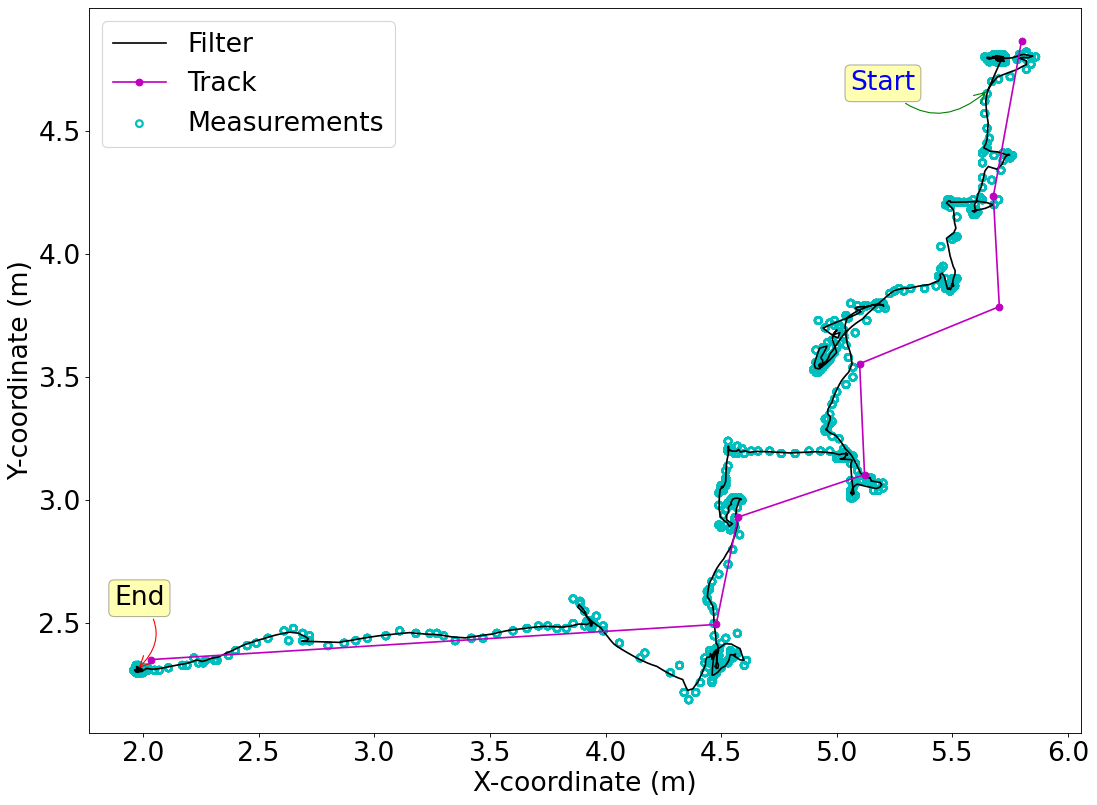

In [58]:
# plot result
plt.figure(figsize=(16, 12), dpi=80)
plt.rcParams.update({'font.size': 24})
# c for color in plot_filter
bp.plot_filter(mu0, mu1, c='k')
bp.plot_measurements(measurements[ini_index1:, 0], measurements[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
# plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
#                             color='green'))
# plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
#                             color='red'))
plt.plot(xs, ys, '-o', color='m', label='Track')
plt.annotate("Start", xy=(mu0[0][0], mu1[0][0]), xytext=(mu0[0][0] - 100, mu1[0][0] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='green'))
plt.annotate("End", xy=(mu0[-1][0], mu1[-1][0]), xytext=(mu0[-1][0], mu1[-1][0] + 50), textcoords='offset points', ha='center', va='bottom',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                            color='red'))
plt.legend(loc='best')